In [29]:
import pandas as pd
import numpy as np
import random
import datetime
import uuid
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly as px

In [30]:
def generate_sales_data(n=2000000):
    """
    Generates a Pandas DataFrame with n rows of sales data,
    including intentional errors for data cleaning practice.
    """
    print(f"Generating {n} rows of data...")

    # --- 1. Generate Core Data (Vectorized for Speed) ---
    
    # Order IDs: UUIDs
    print("Generating UUIDs...")
    order_ids = [str(uuid.uuid4()) for _ in range(n)]
    
    # Dates: Random datetime objects within last 2 years
    print("Generating Dates...")
    base_date = datetime.datetime.now()
    # Generate random seconds offset for 2 years (approx)
    seconds_offset = np.random.randint(0, 63072000, n)
    # Modified: Return YYYY-MM-DD strings directly
    order_dates = [(base_date - datetime.timedelta(seconds=int(x))).strftime('%Y-%m-%d') for x in seconds_offset]
    
    # --- Customer Generation (Consistent Profiles) ---
    print("Generating Customers...")
    # Customers (Simulate fewer unique customers than orders)
    num_customers = n // 5  # e.g., 400k unique customers implies avg 5 orders per customer
    unique_customer_ids = np.arange(1000, 1000 + num_customers)
    
    # Realistic LatAm Names Components
    first_names = ["Juan", "María", "Pedro", "Ana", "Luis", "Carmen", "Carlos", "Josefa", "Jorge", "Isabel", 
                   "Miguel", "Paula", "Francisco", "Elena", "Antonio", "Luisa", "David", "Raquel", "Javier", "Lucía",
                   "Sofía", "Mateo", "Valentina", "Santiago", "Camila", "Sebastián", "Isabella", "Benjamín", "Felipe", "Mariana"]
    last_names = ["González", "Rodríguez", "Pérez", "Fernández", "López", "García", "Martínez", "Sánchez", 
                  "Romero", "Díaz", "Muñoz", "Rojas", "Silva", "Torres", "Vargas", "Ramírez", "Flores", "Acosta",
                  "Gomez", "Morales", "Rivera", "Castillo", "Ortiz", "Gutierrez", "Chavez", "Castro", "Ruiz"]

    # Allowed Countries with Population-based Weights (Approx)
    countries = ["Brasil", "México", "Colombia", "Argentina", "Perú", "Chile", "Ecuador", "Uruguay"]
    # Approx weights based on population (very rough relative scale)
    country_weights = [0.40, 0.25, 0.10, 0.09, 0.07, 0.04, 0.03, 0.02]
    
    # Generate profiles for unique customers
    # We use numpy for fast random choice
    u_firsts = np.random.choice(first_names, num_customers)
    u_lasts = np.random.choice(last_names, num_customers)
    u_countries = np.random.choice(countries, num_customers, p=country_weights)
    
    # Create a mapping DataFrame for customers
    df_customers = pd.DataFrame({
        "customer_id": unique_customer_ids,
        "customer_first": u_firsts,
        "customer_last": u_lasts,
        "customer_country": u_countries
    })

    # Country Code Mapping
    country_code_map = {
        "Brasil": "BRA", "México": "MEX", "Colombia": "COL", "Argentina": "ARG", 
        "Perú": "PER", "Chile": "CHL", "Ecuador": "ECU", "Uruguay": "URY"
    }
    df_customers["country_code"] = df_customers["customer_country"].map(country_code_map)
    
    df_customers["customer_name"] = df_customers["customer_first"] + " " + df_customers["customer_last"]
    
    # Vectorized email generation
    df_customers["customer_email"] = (
        df_customers["customer_first"].str.lower() + "." + 
        df_customers["customer_last"].str.lower() + 
        "_" + df_customers["customer_id"].astype(str) + 
        "@example.com"
    )

    # City generation 
    city_map = {
        "Chile": ["Santiago", "Valparaíso", "Concepción", "La Serena", "Antofagasta", "Temuco", "Rancagua"],
        "Argentina": ["Buenos Aires", "Córdoba", "Rosario", "Mendoza", "La Plata", "Tucumán", "Mar del Plata"],
        "Uruguay": ["Montevideo", "Salto", "Ciudad de la Costa", "Paysandú", "Maldonado"],
        "Perú": ["Lima", "Arequipa", "Trujillo", "Chiclayo", "Cusco", "Piura", "Iquitos"],
        "Colombia": ["Bogotá", "Medellín", "Cali", "Barranquilla", "Cartagena", "Cúcuta", "Bucaramanga"],
        "Brasil": ["São Paulo", "Rio de Janeiro", "Brasília", "Salvador", "Fortaleza", "Belo Horizonte", "Manaus"],
        "Ecuador": ["Guayaquil", "Quito", "Cuenca", "Santo Domingo", "Ambato"],
        "México": ["Ciudad de México", "Guadalajara", "Monterrey", "Puebla", "Tijuana", "León", "Juárez"]
    }
    
    # Assign a random city from the country for each customer
    def get_city(country):
        return np.random.choice(city_map.get(country, ["Unknown"]))
    
    print("Mapping cities to customers...")
    df_customers["customer_city"] = df_customers["customer_country"].apply(get_city)
    
    # Address - randomized
    df_customers["customer_address"] = [f"{random.randint(1,9999)} Calle {random.choice(['Principal', 'Secundaria', 'Norte', 'Sur', 'Este', 'Oeste', 'Los Alamos', 'Los Pinos'])}" for _ in range(num_customers)]

    # Distribute customers to orders
    print("Assigning orders to customers...")
    chosen_customer_ids = np.random.choice(unique_customer_ids, n)
    
    # Map customers to countries for the orders
    customer_country_map = df_customers.set_index("customer_id")["customer_country"]
    # Efficiently map: lookups random array using pandas index
    # We might need to ensure chosen_customer_ids are series/array to map
    order_countries = customer_country_map.loc[chosen_customer_ids].values
    
    # --- Products Generation (Stratified by Country) ---
    # Enhanced product list with realistic prices and weights
    products = [
        {"id": "P001", "name": "Laptop Pro", "cat": "Electronics", "price": 1200.00, "weight": 2.5},
        {"id": "P002", "name": "Smartphone X", "cat": "Electronics", "price": 800.00, "weight": 0.2},
        {"id": "P003", "name": "Wireless Mouse", "cat": "Accessories", "price": 25.50, "weight": 0.1},
        {"id": "P004", "name": "Mechanical Keyboard", "cat": "Accessories", "price": 150.00, "weight": 1.2},
        {"id": "P005", "name": "Monitor 27in", "cat": "Electronics", "price": 300.00, "weight": 5.0},
        {"id": "P006", "name": "Coffee Maker", "cat": "Home", "price": 85.00, "weight": 3.0},
        {"id": "P007", "name": "Blender", "cat": "Home", "price": 45.00, "weight": 2.2},
        {"id": "P008", "name": "Office Chair", "cat": "Furniture", "price": 200.00, "weight": 15.0},
        {"id": "P009", "name": "Running Shoes", "cat": "Fashion", "price": 120.00, "weight": 0.8},
        {"id": "P010", "name": "T-Shirt", "cat": "Fashion", "price": 20.00, "weight": 0.2},
        {"id": "P011", "name": "Smart TV 55in", "cat": "Electronics", "price": 600.00, "weight": 12.0},
        {"id": "P012", "name": "Headphones NoiseCancelling", "cat": "Electronics", "price": 250.00, "weight": 0.3},
        {"id": "P013", "name": "Gaming Console", "cat": "Electronics", "price": 500.00, "weight": 3.5},
        {"id": "P014", "name": "Microwave Oven", "cat": "Home", "price": 150.00, "weight": 10.0},
        {"id": "P015", "name": "Hair Dryer", "cat": "Home", "price": 35.00, "weight": 0.6},
        {"id": "P016", "name": "Sofa 3-Seater", "cat": "Furniture", "price": 800.00, "weight": 45.0},
        {"id": "P017", "name": "Bookshelf", "cat": "Furniture", "price": 120.00, "weight": 18.0},
        {"id": "P018", "name": "Jeans", "cat": "Fashion", "price": 45.00, "weight": 0.5},
        {"id": "P019", "name": "Sneakers", "cat": "Fashion", "price": 85.00, "weight": 0.7},
        {"id": "P020", "name": "Backpack", "cat": "Accessories", "price": 55.00, "weight": 0.4},
    ]
    
    # Define Weights Profiles
    # Profile 1: Tech Enthusiasts (Chile, Uruguay)
    weights_tech = np.array([0.15, 0.15, 0.05, 0.08, 0.10, 0.02, 0.02, 0.05, 0.05, 0.02, 0.10, 0.08, 0.10, 0.01, 0.01, 0.005, 0.005, 0.0, 0.0, 0.0])
    weights_tech /= weights_tech.sum()

    # Profile 2: Fashion/Home (Argentina, Colombia, Peru)
    weights_home = np.array([0.02, 0.05, 0.02, 0.01, 0.02, 0.10, 0.10, 0.05, 0.10, 0.15, 0.05, 0.02, 0.03, 0.08, 0.08, 0.02, 0.02, 0.05, 0.03, 0.0])
    weights_home /= weights_home.sum()

    # Profile 3: Balanced/General (Brasil, Mexico, Ecuador)
    weights_balanced = np.ones(len(products)) / len(products)
    
    print("Generating Products (Weighted by Country)...")
    
    # Pre-allocate arrays
    prod_choices = np.empty(n, dtype=object)
    
    # Vectorized application of weights
    # We'll split indices by country group to apply random choice efficiently
    
    # Group Countries
    countries_tech = ["Chile", "Uruguay"]
    countries_home = ["Argentina", "Colombia", "Perú"]
    countries_balanced = ["Brasil", "México", "Ecuador"]
    
    # Masks
    mask_tech = np.isin(order_countries, countries_tech)
    mask_home = np.isin(order_countries, countries_home)
    mask_balanced = np.isin(order_countries, countries_balanced)
    
    # Generate for Tech group
    if np.any(mask_tech):
        n_tech = np.sum(mask_tech)
        prod_choices[mask_tech] = np.random.choice(products, n_tech, p=weights_tech)
        
    # Generate for Home group
    if np.any(mask_home):
        n_home = np.sum(mask_home)
        prod_choices[mask_home] = np.random.choice(products, n_home, p=weights_home)
        
    # Generate for Balanced group
    if np.any(mask_balanced):
        n_bal = np.sum(mask_balanced)
        prod_choices[mask_balanced] = np.random.choice(products, n_bal, p=weights_balanced)
    
    # Use fallback for any missing holes (shouldn't be any, but good practice)
    mask_filled = mask_tech | mask_home | mask_balanced
    if not np.all(mask_filled):
        n_miss = n - np.sum(mask_filled)
        prod_choices[~mask_filled] = np.random.choice(products, n_miss) # Uniform fallback

    # Extract details
    prod_ids = [p["id"] for p in prod_choices]
    prod_names = [p["name"] for p in prod_choices]
    prod_cats = [p["cat"] for p in prod_choices]
    prod_prices = np.array([p["price"] for p in prod_choices])
    prod_weights = np.array([p["weight"] for p in prod_choices])
    
    # Quantities - Vary slightly by profile too? Let's keep quantities simple but maybe higher for 'Home' items?
    # Keeping quantities random for now to avoid over-complicating.
    quantities = np.random.choice([1, 2, 3, 4, 5, 10], n, p=[0.7, 0.15, 0.1, 0.03, 0.01, 0.01])
    
    # --- New Numeric Variables ---
    print("Calculating financials...")
    # Base Amount
    total_amounts = quantities * prod_prices
    
    # Discount (0%, 5%, 10%, 20%)
    discounts_rates = np.random.choice([0.0, 0.05, 0.10, 0.20], n, p=[0.6, 0.2, 0.15, 0.05])
    discount_amounts = total_amounts * discounts_rates
    
    # Tax (Standard 19% approx for LatAm avg, simplified)
    tax_rate = 0.19
    tax_amounts = (total_amounts - discount_amounts) * tax_rate
    
    # Shipping Cost based on weight
    # Base rate + weight factor
    # Simplify: 5.00 base + 1.50 per kg
    total_weights = quantities * prod_weights
    shipping_costs = 5.00 + (total_weights * 1.50)
    
    # Final Total
    final_totals = (total_amounts - discount_amounts) + tax_amounts + shipping_costs
    
    
    # Additional Columns with Heterogeneous Distribution
    # Rule 1: High Amount (> $1000) -> Mostly Credit Card
    # Rule 2: Brazil -> High Credit Card preference
    # Rule 3: Low Amount (< $50) -> Cash/Debit/PayPal
    
    print("Generating Payment Methods (Correlated)...")
    payment_methods = np.empty(n, dtype=object)
    
    pm_opts = ["Credit Card", "Debit Card", "PayPal", "Bank Transfer"]
    
    # Probability Matrices for vectorized choice
    # We will loop through chunks or valid masks again
    
    # Mask 1: High Value
    mask_high_val = final_totals > 1000
    # Mask 2: Low Value
    mask_low_val = final_totals < 50
    # Mask 3: Brazil (High Credit Use)
    mask_brazil = order_countries == "Brasil"
    # Mask 4: Argentina (Debit/Cash heavy in this simulation)
    mask_arg = order_countries == "Argentina"
    
    # Default selection (Mid range, other countries)
    # Weights: CC 40%, DC 40%, PP 15%, BT 5%
    default_probs = [0.40, 0.40, 0.15, 0.05]
    
    # Logic Application loop (a bit manual but clear)
    # We iterate and assign based on hierarchy or just apply broadly
    
    # Let's generate a base for everyone first
    payment_methods[:] = np.random.choice(pm_opts, n, p=default_probs)
    
    # Apply Overrides
    
    # Brazil Override: CC 70%, DC 20%, PP 5%, BT 5%
    n_br = np.sum(mask_brazil)
    if n_br > 0:
        payment_methods[mask_brazil] = np.random.choice(pm_opts, n_br, p=[0.70, 0.20, 0.05, 0.05])
        
    # Argentina Override: CC 30%, DC 50%, PP 10%, BT 10%
    n_arg = np.sum(mask_arg)
    if n_arg > 0:
        payment_methods[mask_arg] = np.random.choice(pm_opts, n_arg, p=[0.30, 0.50, 0.10, 0.10])
        
    # High Value Override (Global, stronger than country? Maybe)
    # If > 1000, force shifting towards Credit Card/Transfer
    # CC 80%, BT 15%, DC 5%, PP 0%
    n_high = np.sum(mask_high_val)
    if n_high > 0:
        payment_methods[mask_high_val] = np.random.choice(pm_opts, n_high, p=[0.80, 0.05, 0.0, 0.15])
        
    # Low Value Override
    # CC 10%, DC 60%, PP 30%, BT 0%
    n_low = np.sum(mask_low_val)
    if n_low > 0:
        payment_methods[mask_low_val] = np.random.choice(pm_opts, n_low, p=[0.10, 0.60, 0.30, 0.0])

    # Delivered 40%, Shipped 30%, Processing 20%, Cancelled 10%
    shipping_statuses = np.random.choice(
        ["Delivered", "Shipped", "Processing", "Cancelled"], 
        n, 
        p=[0.40, 0.30, 0.20, 0.10]
    )
    
    # --- 2. Create DataFrame ---
    print("Assembling DataFrame...")
    
    # Create the orders DataFrame
    df_orders = pd.DataFrame({
        "order_id": order_ids,
        "order_date": order_dates,
        "customer_id": chosen_customer_ids,
        "product_id": prod_ids,
        "product_name": prod_names,
        "product_category": prod_cats,
        "quantity": quantities,
        "price_per_unit": prod_prices,
        "total_amount_gross": total_amounts,
        "discount_amount": discount_amounts,
        "tax_amount": tax_amounts,
        "shipping_cost": shipping_costs,
        "final_total_amount": final_totals,
        "payment_method": payment_methods,
        "shipping_status": shipping_statuses,
        "total_weight": total_weights
    })
    
    # Merge with customers to get customer details
    # This ensures consistency: same customer_id always has same name/email/country/city
    print("Merging with Customer Data...")
    df = pd.merge(df_orders, df_customers, on="customer_id", how="left")
    
    # Reorder columns for readability
    cols = [
        "order_id", "order_date", 
        "customer_id", "customer_name", "customer_email", "customer_country", "country_code", "customer_city", "customer_address",
        "product_id", "product_name", "product_category", "quantity",
        "price_per_unit", "total_weight", "shipping_cost",
        "total_amount_gross", "discount_amount", "tax_amount", "final_total_amount",
        "payment_method", "shipping_status"
    ]
    df = df[cols]
    
    # --- 3. Inject Errors (Dirty Data) ---
    print("Injecting dirty data...")
    
    # 3.1 Null Values - Categorical/String
    df.loc[df.sample(frac=0.05).index, "customer_email"] = np.nan
    df.loc[df.sample(frac=0.10).index, "shipping_status"] = np.nan
    df.loc[df.sample(frac=0.02).index, "customer_city"] = np.nan

    # 3.2 Null Values - Numeric (Requested)
    # Injecting NaNs into numeric columns for pedagogical variety
    print("Injecting numeric nulls...")
    # 1% nulls in tax_amount
    df.loc[df.sample(frac=0.01).index, "tax_amount"] = np.nan
    # 0.5% nulls in shipping_cost
    df.loc[df.sample(frac=0.005).index, "shipping_cost"] = np.nan
    # 0.1% nulls in total_weight
    df.loc[df.sample(frac=0.001).index, "total_weight"] = np.nan
    # 0.2% nulls in price_per_unit (critical error)
    df.loc[df.sample(frac=0.002).index, "price_per_unit"] = np.nan

    # 3.3 Logic Errors
    # Negative quantities (0.1% of data)
    err_idx_neg = df.sample(frac=0.001).index
    df.loc[err_idx_neg, "quantity"] = df.loc[err_idx_neg, "quantity"] * -1
    
    # Total amount mismatch (0.5% of data) -> Price check fail
    err_idx_math = df.sample(frac=0.005).index
    df.loc[err_idx_math, "final_total_amount"] = df.loc[err_idx_math, "final_total_amount"] * 0.5

    # 3.4 String Format Issues
    # Payment Method casing
    df["payment_method"] = df["payment_method"].apply(lambda x: x.lower() if random.random() < 0.1 else x.upper() if random.random() < 0.1 else x)
    
    # Whitespace in Product Name
    df["product_name"] = df["product_name"].apply(lambda x: f" {x} " if random.random() < 0.05 else x)

    # 3.5 Inconsistent Types (Dates) - FIXED per user request (No invalid dates)
    # We ensure order_date remains as YYYY-MM-DD string
    pass 
    
    # 3.6 Duplicates
    duplicates = df.sample(n=1000)
    df = pd.concat([df, duplicates], ignore_index=True)
    
    print(f"Dataset generated with shape: {df.shape}")
    return df

if __name__ == "__main__":
    # Generate the data
    df_sales = generate_sales_data(2000000)
    
    # Save to CSV
    output_file = "sales_data_dirty_sp7_data.csv"
    print(f"Saving to {output_file}...")
    df_sales.to_csv(output_file, index=False)
    print("Done!")

Generating 2000000 rows of data...
Generating UUIDs...
Generating Dates...
Generating Customers...
Mapping cities to customers...
Assigning orders to customers...
Generating Products (Weighted by Country)...
Calculating financials...
Generating Payment Methods (Correlated)...
Assembling DataFrame...
Merging with Customer Data...
Injecting dirty data...
Injecting numeric nulls...
Dataset generated with shape: (2001000, 22)
Saving to sales_data_dirty_sp7_data.csv...
Done!


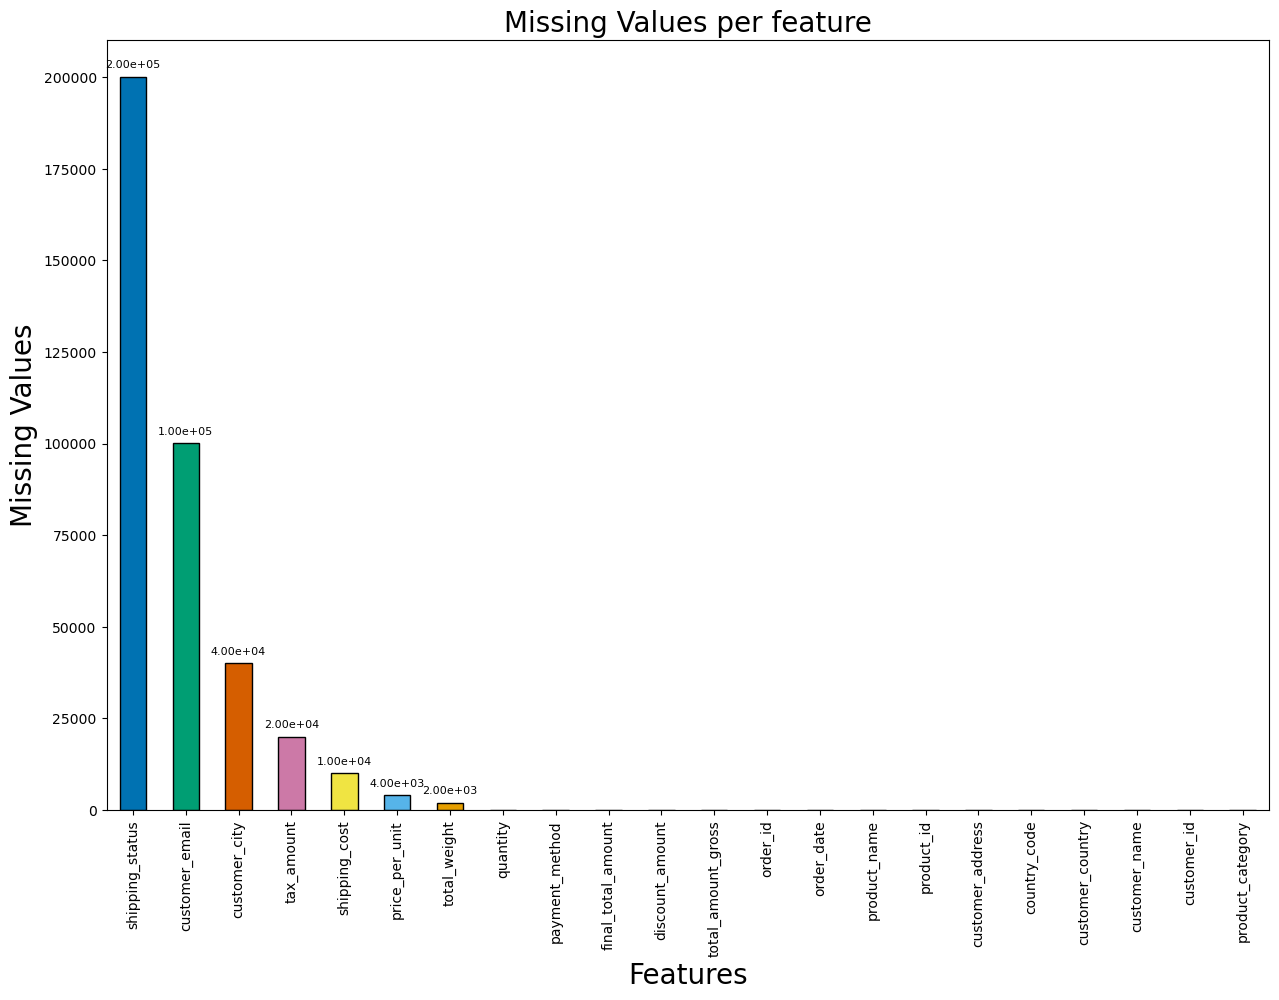

In [31]:
colores_hex = [
    '#0072B2', # Azul
    '#009E73', # Verde Esmeralda
    '#D55E00', # Bermellón
    '#CC79A7', # Púrpura Rojizo
    '#F0E442', # Amarillo
    '#56B4E9', # Azul Cielo
    '#E69F00', # Naranja
    '#999999'  # Gris
]
ax = df_sales.isna().sum().sort_values(ascending=False).plot(kind = 'bar',color = colores_hex ,figsize=(15,10), edgecolor = 'black') 
plt.title("Missing Values per feature",fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Missing Values", fontsize=20) 
conteo = df_sales.isna().sum().sort_values(ascending=False)
labels = [f'{val:.2e}' if val > 0 else '' for val in conteo]

# 3. Aplicamos las etiquetas personalizadas
ax.bar_label(ax.containers[0], labels=labels, padding=5, fontsize=8)
plt.show() 

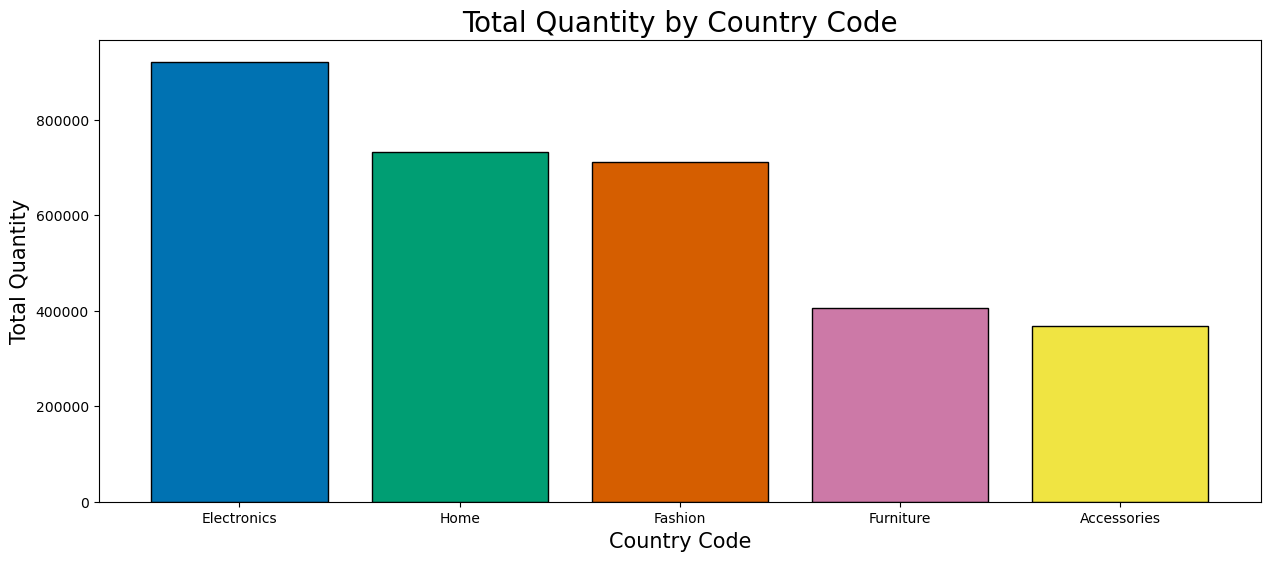

In [32]:
df_grouped = df_sales.groupby('product_category')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

colores_hex = [
    '#0072B2', # Azul
    '#009E73', # Verde Esmeralda
    '#D55E00', # Bermellón
    '#CC79A7', # Púrpura Rojizo
    '#F0E442', # Amarillo
    '#56B4E9', # Azul Cielo
    '#E69F00', # Naranja
    '#999999'  # Gris
]

plt.figure(figsize=(15, 6))
plt.bar(df_grouped['product_category'], df_grouped['quantity'], color=colores_hex, edgecolor='black')
plt.xlabel('Country Code', fontsize = 15)
plt.ylabel('Total Quantity', fontsize = 15)
plt.title('Total Quantity by Country Code', fontsize = 20)

plt.show()

In [33]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [34]:
agg_dict = {'customer_id':['count','nunique'],'order_id':['nunique'],'product_id':'count', 'total_amount_gross':['sum','mean']}

df_sales['payment_method'] = df_sales['payment_method'].str.title().str.strip()

df_agrupado = df_sales.groupby(['payment_method','country_code'])[['customer_id','order_id','product_id','total_amount_gross']].agg(agg_dict).round(2)
df_agrupado.sort_values(by=('customer_id','count'), ascending=False).reset_index()


payment_method country_code customer_id         order_id product_id  \
                                     count nunique  nunique      count   
0     Credit Card          BRA      520439  153853   520165     520439   
1     Credit Card          MEX      212387   88055   212278     212387   
2      Debit Card          MEX      185252   84303   185156     185252   
3      Debit Card          BRA      176712  107001   176631     176712   
4      Debit Card          ARG       86786   32908    86751      86786   
5      Debit Card          COL       81555   34914    81514      81555   
6     Credit Card          COL       75580   34008    75543      75580   
7          Paypal          MEX       72200   51333    72163      72200   
8      Debit Card          PER       56780   24161    56756      56780   
9          Paypal          BRA       55875   47191    55846      55875   
10    Credit Card          ARG       55213   28209    55189      55213   
11    Credit Card          PER       52618   23520    52593      52618   
12  Bank Transfer          BRA       47463   41149    47446      47463   
13    Credit Card          CHL       39710   14691    39693      39710   
14         Paypal          COL       33078   22472    33056      33078   
15  Bank Transfer          MEX       29537   25558    29528      29537   
16    Credit Card          ECU       26099   10794    26084      26099   
17     Debit Card          CHL       25036   12700    25021      25036   
18         Paypal          ARG       23256   17170    23239      23256   
19         Paypal          PER       22923   15586    22914      22923   
20     Debit Card          ECU       22743   10320    22726      22743   
21    Credit Card          URY       19526    7196    19512      19526   
22  Bank Transfer          ARG       15429   12555    15423      15429   
23     Debit Card          URY       12418    6267    12410      12418   
24  Bank Transfer          COL        9828    8736     9825       9828   
25         Paypal          CHL        9440    7097     9437       9440   
26         Paypal          ECU        8904    6379     8901       8904   
27  Bank Transfer          PER        6954    6145     6952       6954   
28  Bank Transfer          CHL        6135    5096     6130       6135   
29         Paypal          URY        4657    3517     4653       4657   
30  Bank Transfer          ECU        3496    3047     3494       3496   
31  Bank Transfer          URY        2971    2449     2971       2971   

   total_amount_gross           
                  sum     mean  
0         263899768.5   507.07  
1         135566444.0   638.30  
2          44998094.5   242.90  
3          41736580.0   236.18  
4          16604754.0   191.33  
5          15025442.0   184.24  
6          35825793.5   474.01  
7          14765342.5   204.51  
8          10448826.5   184.02  
9           8362036.5   149.66  
10         29235940.5   529.51  
11         25347547.0   481.73  
12         37575774.0   791.69  
13         41406031.5  1042.71  
14          5196214.5   157.09  
15         23083746.0   781.52  
16         16809813.5   644.08  
17         10677337.0   426.48  
18          3229486.5   138.87  
19          3594337.5   156.80  
20          5578184.0   245.27  
21         20417943.5  1045.68  
22          6779265.0   439.38  
23          5370284.0   432.46  
24          5800989.5   590.25  
25          3312754.0   350.93  
26          1807993.0   203.05  
27          4113785.0   591.57  
28          7336229.0  1195.80  
29          1669555.0   358.50  
30          2852828.5   816.03  
31          3567331.0  1200.72

In [35]:
print((100*df_sales['shipping_status'].value_counts(normalize = True)).round(3))

shipping_status
Delivered     40.044
Shipped       29.963
Processing    19.989
Cancelled     10.004
Name: proportion, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_25140\2237363092.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_sales['payment_method'], y =df_sales['total_amount_gross'], data = df_sales, palette = 'viridis')


<Axes: xlabel='payment_method', ylabel='total_amount_gross'>

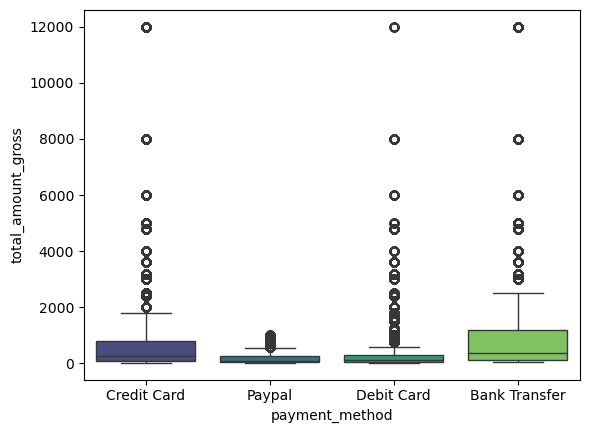

In [36]:
sns.boxplot(x=df_sales['payment_method'], y =df_sales['total_amount_gross'], data = df_sales, palette = 'viridis') 

In [37]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [38]:
dimensiones = ['country_code','product_category']
metricas    = ['total_amount_gross', 'shipping_cost','discount_amount']
agg_dic     = {'total_amount_gross': ['sum','max','min','mean'],
               'shipping_cost'     : ['sum','max','min','mean'],
               'discount_amount'   : ['sum','max','min','mean']}

df_grouped = df_sales.groupby(dimensiones)[metricas].agg(agg_dic).sort_values(by = ('total_amount_gross','sum'), ascending = False)
df_grouped.reset_index().to_excel('Grouped_sales_data.xlsx', index = True)

In [39]:
diccionario = {"nombre": "Juan", "edad": 30, "ciudad": "Madrid"}

x = (2,4)
x[1]

4

In [40]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [41]:
df_sales.describe()

,customer_id,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount
count,2.001000e+06,2.001000e+06,1.996998e+06,1.999000e+06,1.990994e+06,2.001000e+06,2.001000e+06,1.980992e+06,2.001000e+06
mean,2.009760e+05,1.568496e+00,2.711174e+02,8.655013e+00,1.798472e+01,4.257853e+02,1.490580e+01,7.807105e+01,5.056375e+02
std,1.154657e+05,1.217279e+00,3.186287e+02,1.996879e+01,2.995836e+01,7.125100e+02,5.059101e+01,1.308420e+02,8.312510e+02
min,1.000000e+03,-1.000000e+01,2.000000e+01,1.000000e-01,5.150000e+00,2.000000e+01,0.000000e+00,3.040000e+00,1.217000e+01
25%,1.009758e+05,1.000000e+00,4.500000e+01,6.000000e-01,5.900000e+00,7.000000e+01,0.000000e+00,1.292000e+01,8.697000e+01
50%,2.009210e+05,1.000000e+00,1.200000e+02,2.200000e+00,8.300000e+00,1.500000e+02,0.000000e+00,2.850000e+01,1.985000e+02
75%,3.009932e+05,2.000000e+00,3.000000e+02,1.000000e+01,2.000000e+01,5.000000e+02,8.500000e+00,9.500000e+01,6.052500e+02
max,4.009990e+05,1.000000e+01,1.200000e+03,4.500000e+02,6.800000e+02,1.200000e+04,2.400000e+03,2.280000e+03,1.432250e+04


In [42]:
df_sales.isna().sum()

order_id                   0
order_date                 0
customer_id                0
customer_name              0
customer_email        100051
customer_country           0
country_code               0
customer_city          40018
customer_address           0
product_id                 0
product_name               0
product_category           0
quantity                   0
price_per_unit          4002
total_weight            2000
shipping_cost          10006
total_amount_gross         0
discount_amount            0
tax_amount             20008
final_total_amount         0
payment_method             0
shipping_status       200118
dtype: int64

In [43]:
df_sales.columns

Index(['order_id', 'order_date', 'customer_id', 'customer_name',
       'customer_email', 'customer_country', 'country_code', 'customer_city',
       'customer_address', 'product_id', 'product_name', 'product_category',
       'quantity', 'price_per_unit', 'total_weight', 'shipping_cost',
       'total_amount_gross', 'discount_amount', 'tax_amount',
       'final_total_amount', 'payment_method', 'shipping_status'],
      dtype='object')

In [44]:
dimensiones = ['country_code']


metricas    = ['quantity',
                'total_amount_gross',
                'shipping_cost',
                'discount_amount',
                'price_per_unit',
                'total_weight',
                'tax_amount',
                'final_total_amount',
                'order_id','customer_id']


agg_dic     = { 'quantity'          : ['sum','max','min','mean'],
                'total_amount_gross': ['sum','max','min','mean'],
                'shipping_cost'     : ['sum','max','min','mean'],
                'discount_amount'   : ['sum','max','min','mean'],
                'price_per_unit'    : ['sum','max','min','mean'],
                'total_weight'      : ['sum','max','min','mean'],
                'tax_amount'        : ['sum','max','min','mean'],
                'final_total_amount': ['sum','max','min','mean'],
                'order_id'          : ['count','nunique'],
                'customer_id'       : ['count','nunique']}

df_grouped = df_sales.groupby(dimensiones)[metricas].agg(agg_dic).sort_values(by = ('final_total_amount','sum'), ascending = False)
df_grouped.reset_index()

country_code quantity                   total_amount_gross                 \
                    sum max min      mean                sum      max   min   
0          BRA  1255425  10 -10  1.568323        351574159.0  12000.0  20.0   
1          MEX   783380  10 -10  1.568718        218413627.0  12000.0  20.0   
2          COL   313285  10  -4  1.566104         61848439.5  12000.0  20.0   
3          CHL   125505  10  -5  1.562543         62732351.5  12000.0  20.0   
4          ARG   283924  10 -10  1.571384         55849446.0  12000.0  20.0   
5          PER   219171  10 -10  1.573656         43504496.0  12000.0  20.0   
6          URY    61996  10  -4  1.566663         31025113.5  12000.0  20.0   
7          ECU    95874  10 -10  1.565494         27048819.0  12000.0  20.0   

              shipping_cost                         discount_amount          \
         mean           sum    max   min       mean             sum     max   
0  439.199238   15377414.15  680.0  5.15  19.307444    1.236720e+07  2400.0   
1  437.373096    9591511.45  680.0  5.15  19.302428    7.575223e+06  2400.0   
2  309.178816    3054598.10  680.0  5.15  15.346500    2.148502e+06  2400.0   
3  781.020549    1135564.05  680.0  5.15  14.210893    2.208085e+06  2400.0   
4  309.100120    2768958.45  680.0  5.15  15.400300    1.961985e+06  2400.0   
5  312.363999    2142005.50  680.0  5.15  15.458377    1.528320e+06  2400.0   
6  784.016817     557417.60  680.0  5.15  14.151965    1.089993e+06  2400.0   
7  441.671059    1180007.75  680.0  5.15  19.365342    9.471885e+05  2400.0   

                  price_per_unit                           total_weight  \
   min       mean            sum     max   min        mean          sum   
0  0.0  15.449558    223222454.5  1200.0  20.0  279.419255    7625864.9   
1  0.0  15.169377    138791438.0  1200.0  20.0  278.494668    4754898.1   
2  0.0  10.740311     39353350.0  1200.0  20.0  197.124531    1379001.4   
3  0.0  27.490761     40039835.0  1200.0  20.0  499.486477     492556.9   
4  0.0  10.858652     35664255.0  1200.0  20.0  197.761201    1251929.6   
5  0.0  10.973400     27476593.5  1200.0  20.0  197.706048     969939.7   
6  0.0  27.544563     19736381.0  1200.0  20.0  499.718471     241375.2   
7  0.0  15.466323     17136648.5  1200.0  20.0  280.267050     585804.7   

                           tax_amount                            \
     max  min      mean           sum     max   min        mean   
0  450.0  0.1  9.536396  6.379858e+07  2280.0  3.04   80.508832   
1  450.0  0.1  9.531222  3.965673e+07  2280.0  3.04   80.211667   
2  450.0  0.1  6.900251  1.123869e+07  2280.0  3.04   56.737556   
3  450.0  0.1  6.139158  1.139387e+07  2280.0  3.04  143.292024   
4  450.0  0.1  6.935591  1.012723e+07  2280.0  3.04   56.632082   
5  450.0  0.1  6.970461  7.894208e+06  2280.0  3.04   57.257102   
6  450.0  0.1  6.103194  5.632265e+06  2280.0  3.04  143.702224   
7  450.0  0.1  9.575414  4.916563e+06  2280.0  3.04   81.051152   

  final_total_amount                              order_id          \
                 sum      max     min        mean    count nunique   
0       4.180163e+08  14322.5  12.170  522.201148   800489  800088   
1       2.598758e+08  14322.5  12.170  520.400978   499376  499125   
2       7.391816e+07  14322.5  12.170  369.515034   200041  199938   
3       7.296819e+07  14322.5  13.360  908.457180    80321   80281   
4       6.674898e+07  14322.5  12.170  369.423850   180684  180602   
5       5.200206e+07  14322.5  12.170  373.376862   139275  139215   
6       3.608589e+07  14322.5  13.955  911.904705    39572   39546   
7       3.216537e+07  14322.5  13.360  525.217536    61242   61205   

  customer_id          
        count nunique  
0      800489  158912  
1      499376   99350  
2      200041   39777  
3       80321   15962  
4      180684   35823  
5      139275   27532  
6       39572    7832  
7       61242   12154

In [45]:
df_sales[df_sales.duplicated(keep = False)].sort_values(by = 'order_id', ascending = False).head(2)

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status
490134,ffa9c864-0c39-4098-acbc-18ba2835a5a4,2025-06-03,350055,Sofía Acosta,sofía.acosta_350055@example.com,México,MEX,Puebla,8460 Calle Los Pinos,P018,Jeans,Fashion,1,45.0,0.5,5.75,45.0,0.0,8.55,59.3,Credit Card,Processing
2000876,ffa9c864-0c39-4098-acbc-18ba2835a5a4,2025-06-03,350055,Sofía Acosta,sofía.acosta_350055@example.com,México,MEX,Puebla,8460 Calle Los Pinos,P018,Jeans,Fashion,1,45.0,0.5,5.75,45.0,0.0,8.55,59.3,Credit Card,Processing


In [46]:
df_sales.drop_duplicates(keep = 'first', inplace = True)

In [47]:
df_sales['quantity'] = df_sales['quantity'].abs()

In [48]:
df_sales[df_sales['quantity'] < 0]

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status


In [49]:
df_sales.dtypes

order_id               object
order_date             object
customer_id             int32
customer_name          object
customer_email         object
customer_country       object
country_code           object
customer_city          object
customer_address       object
product_id             object
product_name           object
product_category       object
quantity                int32
price_per_unit        float64
total_weight          float64
shipping_cost         float64
total_amount_gross    float64
discount_amount       float64
tax_amount            float64
final_total_amount    float64
payment_method         object
shipping_status        object
dtype: object

In [50]:
df_sales.head()

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status
0,69b4677c-dda0-4a7b-9838-d3a9281fb892,2024-12-14,118478,Mateo Flores,mateo.flores_118478@example.com,Brasil,BRA,Fortaleza,8157 Calle Secundaria,P004,Mechanical Keyboard,Accessories,1,150.0,1.2,6.80,150.0,0.0,28.50,185.30,Credit Card,Delivered
1,fc7c7db3-5d3e-4508-874b-a39f46604115,2024-11-27,144804,Carmen Gutierrez,carmen.gutierrez_144804@example.com,Brasil,BRA,Belo Horizonte,83 Calle Los Alamos,P013,Gaming Console,Electronics,1,500.0,3.5,10.25,500.0,0.0,95.00,605.25,Credit Card,Shipped
2,c868b66f-ae61-45fa-a7cd-c0b845b8e764,2025-06-26,270479,Lucía Fernández,lucía.fernández_270479@example.com,Colombia,COL,Bogotá,9850 Calle Norte,P019,Sneakers,Fashion,1,85.0,0.7,6.05,85.0,0.0,16.15,107.20,Credit Card,Delivered
3,064ccf36-4f00-460c-a17f-211caf1cfc95,2025-08-07,386249,Josefa Rojas,josefa.rojas_386249@example.com,Brasil,BRA,Rio de Janeiro,3258 Calle Norte,P014,Microwave Oven,Home,3,150.0,30.0,50.00,450.0,45.0,76.95,531.95,Credit Card,Processing
4,b874fe7e-6ce4-40b7-8b40-2110eeb3bb12,2024-03-26,304226,Mariana Ramírez,mariana.ramírez_304226@example.com,México,MEX,Juárez,5353 Calle Principal,P011,Smart TV 55in,Electronics,2,600.0,24.0,41.00,1200.0,0.0,228.00,1469.00,Credit Card,Processing


In [51]:
df_sales.head()

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status
0,69b4677c-dda0-4a7b-9838-d3a9281fb892,2024-12-14,118478,Mateo Flores,mateo.flores_118478@example.com,Brasil,BRA,Fortaleza,8157 Calle Secundaria,P004,Mechanical Keyboard,Accessories,1,150.0,1.2,6.80,150.0,0.0,28.50,185.30,Credit Card,Delivered
1,fc7c7db3-5d3e-4508-874b-a39f46604115,2024-11-27,144804,Carmen Gutierrez,carmen.gutierrez_144804@example.com,Brasil,BRA,Belo Horizonte,83 Calle Los Alamos,P013,Gaming Console,Electronics,1,500.0,3.5,10.25,500.0,0.0,95.00,605.25,Credit Card,Shipped
2,c868b66f-ae61-45fa-a7cd-c0b845b8e764,2025-06-26,270479,Lucía Fernández,lucía.fernández_270479@example.com,Colombia,COL,Bogotá,9850 Calle Norte,P019,Sneakers,Fashion,1,85.0,0.7,6.05,85.0,0.0,16.15,107.20,Credit Card,Delivered
3,064ccf36-4f00-460c-a17f-211caf1cfc95,2025-08-07,386249,Josefa Rojas,josefa.rojas_386249@example.com,Brasil,BRA,Rio de Janeiro,3258 Calle Norte,P014,Microwave Oven,Home,3,150.0,30.0,50.00,450.0,45.0,76.95,531.95,Credit Card,Processing
4,b874fe7e-6ce4-40b7-8b40-2110eeb3bb12,2024-03-26,304226,Mariana Ramírez,mariana.ramírez_304226@example.com,México,MEX,Juárez,5353 Calle Principal,P011,Smart TV 55in,Electronics,2,600.0,24.0,41.00,1200.0,0.0,228.00,1469.00,Credit Card,Processing


In [52]:
df_sales[df_sales['order_date'].isna()].shape

(0, 22)

In [53]:
dimensiones = ['shipping_status']


metricas    = ['quantity',
                'total_amount_gross',
                'shipping_cost',
                'discount_amount',
                'price_per_unit',
                'total_weight',
                'tax_amount',
                'final_total_amount',
                'order_id','customer_id']


agg_dic     = { 'quantity'          : ['sum','max','min','mean'],
                'total_amount_gross': ['sum','max','min','mean'],
                'shipping_cost'     : ['sum','max','min','mean'],
                'discount_amount'   : ['sum','max','min','mean'],
                'price_per_unit'    : ['sum','max','min','mean'], 
                'total_weight'      : ['sum','max','min','mean'],
                'tax_amount'        : ['sum','max','min','mean'],
                'final_total_amount': ['sum','max','min','mean'],
                'order_id'          : ['count','nunique'],
                'customer_id'       : ['count','nunique']}

df_grouped = df_sales.groupby(dimensiones)[metricas].agg(agg_dic).sort_values(by = ('final_total_amount','sum'), ascending = False)
df_grouped.reset_index()

shipping_status quantity                   total_amount_gross           \
                       sum max min      mean                sum      max   
0       Delivered  1133522  10   1  1.572604        306905045.0  12000.0   
1         Shipped   848445  10   1  1.573138        230216183.0  12000.0   
2      Processing   564712  10   1  1.569521        153021844.5  12000.0   
3       Cancelled   283033  10   1  1.571751         76878127.0  12000.0   

                    shipping_cost                         discount_amount  \
    min        mean           sum    max   min       mean             sum   
0  20.0  425.788049   12908207.90  680.0  5.15  17.997632    1.071767e+07   
1  20.0  426.853508    9665652.65  680.0  5.15  18.011193    8.101085e+06   
2  20.0  425.298137    6427432.90  680.0  5.15  17.954425    5.339413e+06   
3  20.0  426.922821    3218963.60  680.0  5.15  17.968983    2.684081e+06   

                          price_per_unit                            \
      max  min       mean            sum     max   min        mean   
0  2400.0  0.0  14.869281    194988256.0  1200.0  20.0  271.080950   
1  2400.0  0.0  15.020562    145937244.0  1200.0  20.0  271.122753   
2  2400.0  0.0  14.839989     97362759.5  1200.0  20.0  271.113325   
3  2400.0  0.0  14.905350     48762392.0  1200.0  20.0  271.328767   

  total_weight                          tax_amount                           \
           sum    max  min      mean           sum     max   min       mean   
0    6238314.0  450.0  0.1  8.662905  5.570744e+07  2280.0  3.04  78.069188   
1    4671530.9  450.0  0.1  8.670862  4.177503e+07  2280.0  3.04  78.254142   
2    3103845.7  450.0  0.1  8.635154  2.778743e+07  2280.0  3.04  78.005729   
3    1555143.5  450.0  0.1  8.645065  1.395965e+07  2280.0  3.04  78.289955   

  final_total_amount                             order_id         customer_id  \
                 sum      max    min        mean    count nunique       count   
0       3.644895e+08  14322.5  12.17  505.678520   720793  720793      720793   
1       2.733234e+08  14322.5  12.17  506.780383   539333  539333      539333   
2       1.817724e+08  14322.5  12.17  505.205480   359799  359799      359799   
3       9.127965e+07  14322.5  12.17  506.897944   180075  180075      180075   

           
  nunique  
0  334271  
1  296388  
2  237304  
3  145000

In [54]:
df_sales['shipping_status'].value_counts(dropna = False)

shipping_status
Delivered     720793
Shipped       539333
Processing    359799
NaN           200000
Cancelled     180075
Name: count, dtype: int64

In [55]:
df_sales[df_sales['shipping_status'].isna()].head(10)

,order_id,order_date,customer_id,customer_name,customer_email,customer_country,country_code,customer_city,customer_address,product_id,product_name,product_category,quantity,price_per_unit,total_weight,shipping_cost,total_amount_gross,discount_amount,tax_amount,final_total_amount,payment_method,shipping_status
16,bf2796c5-09af-401c-afc1-229106b93f9c,2025-07-13,153882,Lucía Martínez,lucía.martínez_153882@example.com,Colombia,COL,Cali,4400 Calle Oeste,P007,Blender,Home,2,45.0,4.4,11.60,90.0,4.50,16.2450,113.3450,Debit Card,NaN
34,096e00c8-495c-4d3f-8447-14ceb0c77814,2025-02-07,136752,Luisa García,luisa.garcía_136752@example.com,Perú,PER,Chiclayo,9789 Calle Norte,P010,T-Shirt,Fashion,1,20.0,0.2,5.30,20.0,0.00,3.8000,29.1000,Paypal,NaN
36,365ea48f-65f9-458a-8ebd-e757b2d9d5ca,2024-12-06,204014,Luis Flores,luis.flores_204014@example.com,México,MEX,León,1670 Calle Los Alamos,P003,Wireless Mouse,Accessories,2,25.5,0.2,5.30,51.0,0.00,9.6900,65.9900,Credit Card,NaN
40,4d588d7d-e351-45bb-83ca-bd09947bf69b,2025-07-08,5350,Francisco González,francisco.gonzález_5350@example.com,México,MEX,Guadalajara,2054 Calle Los Pinos,P015,Hair Dryer,Home,1,35.0,0.6,5.90,35.0,1.75,6.3175,45.4675,Paypal,NaN
55,79a96bd0-f93b-4bd1-81ce-a7c71d549864,2025-03-22,50959,Mateo Rodríguez,mateo.rodríguez_50959@example.com,México,MEX,Monterrey,996 Calle Principal,P018,Jeans,Fashion,1,45.0,0.5,5.75,45.0,4.50,7.6950,53.9450,Credit Card,NaN
67,a6aed534-2d1f-4ae7-9b59-850718364f2c,2025-12-29,54430,Luisa Flores,luisa.flores_54430@example.com,Brasil,BRA,Rio de Janeiro,7302 Calle Sur,P006,Coffee Maker,Home,1,85.0,3.0,9.50,85.0,0.00,16.1500,110.6500,Credit Card,NaN
69,23837446-7d00-46d4-b91f-59cdbb3af6ff,2024-09-23,359837,Mariana Romero,mariana.romero_359837@example.com,México,MEX,Tijuana,3930 Calle Principal,P008,Office Chair,Furniture,1,200.0,15.0,27.50,200.0,0.00,38.0000,265.5000,Credit Card,NaN
95,81ea5391-6845-4d22-81f8-8900c10748fb,2024-09-15,271545,Miguel Silva,miguel.silva_271545@example.com,México,MEX,León,699 Calle Principal,P018,Jeans,Fashion,1,45.0,0.5,5.75,45.0,2.25,8.1225,56.6225,Credit Card,NaN
104,23d1ccd7-ffbf-4416-977c-484f8eb0989d,2024-06-02,237265,Luisa Muñoz,luisa.muñoz_237265@example.com,Brasil,BRA,Belo Horizonte,6488 Calle Sur,P012,Headphones NoiseCancelling,Electronics,1,250.0,0.3,5.45,250.0,0.00,47.5000,302.9500,Credit Card,NaN
122,040c05a3-363a-4c68-8cdb-b60d334051a4,2025-01-28,70797,Elena Gutierrez,elena.gutierrez_70797@example.com,México,MEX,Tijuana,1625 Calle Secundaria,P002,Smartphone X,Electronics,1,800.0,0.2,5.30,800.0,40.00,144.4000,909.7000,Credit Card,NaN


In [56]:
df_sales.isna().sum()

order_id                   0
order_date                 0
customer_id                0
customer_name              0
customer_email        100000
customer_country           0
country_code               0
customer_city          40000
customer_address           0
product_id                 0
product_name               0
product_category           0
quantity                   0
price_per_unit          4000
total_weight            2000
shipping_cost          10000
total_amount_gross         0
discount_amount            0
tax_amount             20000
final_total_amount         0
payment_method             0
shipping_status       200000
dtype: int64